In [9]:
#Import two moons
from sklearn.datasets import make_moons
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
import time
import ot

In [10]:
class MoonsDataset(Dataset):
    def __init__(self, n_samples, device, noise=0.05):
        X, _ = make_moons(n_samples=n_samples, noise=noise)
        X = torch.tensor(X, dtype=torch.float32)
        self.X = X.to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]
    
    def get_whole_dataset(self):
        return self.X

def time_horizon(epsilon=0.002, T=80, rho=7, N=18, device='cpu'):
    """
    Compute the value of t following the formula at the bottom left page 4 of the paper.
    The horizon is flipped compared to the paper because we want to start with the largest value of t.
    epsilon is the minmum std of the noise
    T is the maximum std of the noise
    N is the number of steps
    """
    return torch.tensor([(T ** (1/rho) + (i-1)/(N-1) * (epsilon**(1/rho) - T**(1/rho)))**rho for i in range(1, N+1)]).to(device).type(torch.float32)

def N_scheduled(k, K, s0=2, s1=20):
    """
    Compute the value of N following the formula p26
    k is the current step
    K is the total number of steps
    """
    return math.ceil((k / K * ((s1 + 1)**2 - s0**2) + s0**2)**0.5 - 1) + 1

def ema_decay_rate_schedule(N, s0=2, mu0=0.9):
    """
    Compute the exponential moving average decay rate following the formula p26
    """
    return np.exp(s0 * np.log(mu0) / N)

class ConsistencyModel(torch.nn.Module):
    def __init__(self, dim, device, epsilon=0.002, sigma_data=0.5, n_layers=3, n_units=256):
        super().__init__()
        self.epsilon = epsilon
        self.sigma_data = sigma_data
        self.dim = dim
        self.device = device
        self.n_layers = n_layers
        self.n_units = n_units
        self.linear1 = torch.nn.Sequential(torch.nn.Linear(dim, n_units).to(device), torch.nn.GELU())
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(n_units, n_units).to(device), torch.nn.GELU()) for _ in range(n_layers)])
        self.final_layer = torch.nn.Linear(n_units, dim).to(device)

    
    def c_skip(self, t):
        return (self.sigma_data ** 2 / ((t - self.epsilon) ** 2 + self.sigma_data ** 2))[:, None]

    def c_out(self, t):
        return (self.sigma_data * (t - self.epsilon) / (self.sigma_data ** 2 + t **2) ** 0.5)[:, None]

    def time_embedding(self, t, dim, max_period=10000):
        """
        Compute the time embedding
        timesteps: a batch of times (1D tensor)
        dim: the dimension of the embedding
        """
        half_dim = dim // 2
        freqs = t[:, None] / max_period  ** (2 * torch.arange(half_dim, device=self.device) / dim)
        return torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=1).to(self.device)
    
    def F(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step index
        """
        time_embed = self.time_embedding(t, self.n_units).to(self.device) # Compute the time embedding
        y = self.linear1(x) # Apply the first linear layer which differs from the other layers
        
        # Apply the layers
        for layer in self.layers:
            y += time_embed # Add the time embedding to the input
            y = layer(y) # Apply the layer
        return self.final_layer(y)

    def forward(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step index
        The formula is from the right column of p3 of the original paper. 
        """
        return self.c_skip(t) * x + self.c_out(t) * self.F(x, t)
   
def consistency_training_loop(target_model, dataloader, device, lr = 1e-3, n_epochs=2000, epsilon=0.002, T=80, rho=7, ema=True):
    print(f"Training the consistency model with the following parameters: n_epochs={n_epochs}, lr={lr}, epsilon={epsilon}, T={T}, rho={rho}, ema={ema}")

    if ema:
        online_model = copy.deepcopy(target_model).to(device)
    else:
        online_model = target_model
    optimizer = torch.optim.Adam(online_model.parameters(), lr=lr)

    batch_size = dataloader.batch_size
    dataset_size = len(dataloader.dataset)
    training_iterations = n_epochs * (dataset_size // batch_size) # Compute the total number of training iterations 
    k = 0
    losses = []

    start = time.time()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for X in dataloader:
            optimizer.zero_grad() # Zero the gradients
            N = N_scheduled(k, training_iterations) # Follow the schedule to compute N
            Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon for the current N
            Ts = torch.flip(Ts, [0]) # Flip the time horizon because I implemented it in reverse order...
            n = torch.randint(0, N-1, (batch_size,)) # Sample random time steps in the current time horizon
            z = torch.randn_like(X) # Sample random noise latents
            loss = torch.nn.functional.mse_loss(online_model(X + z * Ts[n+1][:, None], Ts[n+1]), target_model(X + z * Ts[n][:, None], Ts[n])) # Compute the loss following eq10 in the paper
            loss.backward() # Backward pass
            optimizer.step() # Optimize the model
            running_loss += loss.item() # Add the loss to the running loss

            mu = ema_decay_rate_schedule(N) # Compute the exponential moving average decay rate following the schedule
            for online_p, target_p in zip(online_model.parameters(), target_model.parameters()): # Update the online model using the exponential moving average
                target_p.data = mu * target_p.data + (1 - mu) * online_p.data

            k += 1 # Increment k as done in Algorithm 3 of the paper
        losses.append(running_loss / len(dataloader)) # Append the average loss to the losses list
        if (epoch+1) % 25 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss / len(dataloader):.4f}")
    end = time.time()
    print(f"Training took {end - start:.2f} seconds")

    plt.plot(losses, color = 'green') # Plot the losses in green
    plt.xlabel("Epoch")
    plt.ylabel("Loss(MSE)")
    plt.title("Consistency Training Loss")
    plt.show()


def consistency_single_step_sampling(model, device, batch_size=64, T=80):
    """
    Sample a gaussian noise and denoise it in a single step using the consistency model.
    """
    z = torch.randn(batch_size, 2, device=device) * T # Sample the latents by sampling a batch of gaussian noise with the maximum std
    batched_T = torch.full((batch_size,), T, device=device) # Create a batched time index
    denoised_x = model(z, batched_T) # Denoise the latents using the consistency model
    return denoised_x.detach().cpu().clone()

def consistency_multiple_step_sampling(model, device, batch_size=64, times = [80, 0.002], epsilon=0.002):
    """
    Multistep Consistency Sampling from Algorithm 1 in the left column of p4 of the paper
    """
    x_evolution = [] # List to store the evolution of the denoising process

    z = torch.randn(batch_size, 2, device=device) # Sample the latents by sampling a batch of gaussian noise with the maximum std
    x_noisy = z * times[0] # Initialize the noisy latents as the sampled latents scaled by the maximum std
    batched_T = torch.full((batch_size,), times[0], device=device) # Create a batched time
    x = model(x_noisy, batched_T) # Denoise the latents using the consistency model
    x_evolution.append(x.detach().cpu().clone()) # Append the denoised latents to the list

    for t in times[1:]:
        z = torch.randn(batch_size, 2, device=device) # Sample noise
        x_noisy = x + z * (t**2 - epsilon**2)**0.5 # Add noise to the previous x
        batched_t = torch.full((batch_size,), t, device=device) # Create a batched time index
        x = model(x_noisy, batched_t) # Denoise the latents using the consistency model
        x_evolution.append(x.detach().cpu().clone()) # Append the denoised latents to the list

    return x_evolution

In [11]:
dataset_size = 16384
training_batch_size = 256
training_iterations = 100000
n_epochs = training_iterations // (dataset_size // training_batch_size)
epsilon = 0.002
T = 80
rho = 7
n_units = 512
n_layers = 5
dim = 2
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

Training the consistency model with the following parameters: n_epochs=1562, lr=0.001, epsilon=0.002, T=80, rho=7, ema=True
Epoch 25/1562 - Loss: 0.1361
Epoch 50/1562 - Loss: 0.1001
Epoch 75/1562 - Loss: 0.1042
Epoch 100/1562 - Loss: 0.0687
Epoch 125/1562 - Loss: 0.0558
Epoch 150/1562 - Loss: 0.0554
Epoch 175/1562 - Loss: 0.0436
Epoch 200/1562 - Loss: 0.0419
Epoch 225/1562 - Loss: 0.0329
Epoch 250/1562 - Loss: 0.0352
Epoch 275/1562 - Loss: 0.0344
Epoch 300/1562 - Loss: 0.0275
Epoch 325/1562 - Loss: 0.0281
Epoch 350/1562 - Loss: 0.0232
Epoch 375/1562 - Loss: 0.0239
Epoch 400/1562 - Loss: 0.0236
Epoch 425/1562 - Loss: 0.0205
Epoch 450/1562 - Loss: 0.0201
Epoch 475/1562 - Loss: 0.0205
Epoch 500/1562 - Loss: 0.0198
Epoch 525/1562 - Loss: 0.0175
Epoch 550/1562 - Loss: 0.0176
Epoch 575/1562 - Loss: 0.0167
Epoch 600/1562 - Loss: 0.0152
Epoch 625/1562 - Loss: 0.0150
Epoch 650/1562 - Loss: 0.0155
Epoch 675/1562 - Loss: 0.0154
Epoch 700/1562 - Loss: 0.0133
Epoch 725/1562 - Loss: 0.0135
Epoch 750

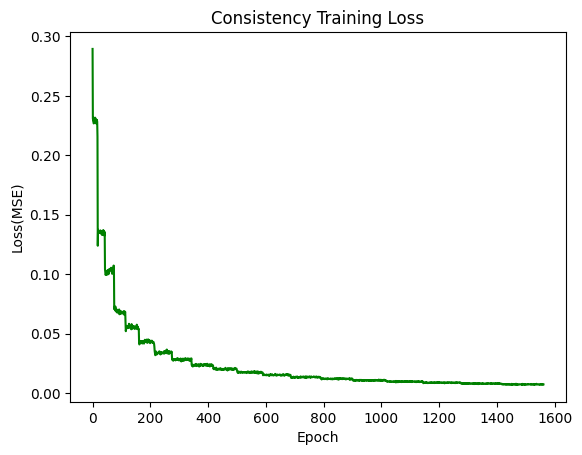

In [12]:
# Create the dataset
dataset = MoonsDataset(dataset_size, device)
dataloader = DataLoader(dataset, batch_size=training_batch_size, shuffle=True)

# Create the model
model = ConsistencyModel(dim, device, epsilon=epsilon, n_units=n_units, n_layers=n_layers).to(device)

# Train the model
losses = consistency_training_loop(model, dataloader, device, lr = learning_rate, n_epochs=n_epochs, epsilon=epsilon, T=T, rho=rho, ema=True)

Single step sampling took 0.017 +/- 0.016 seconds


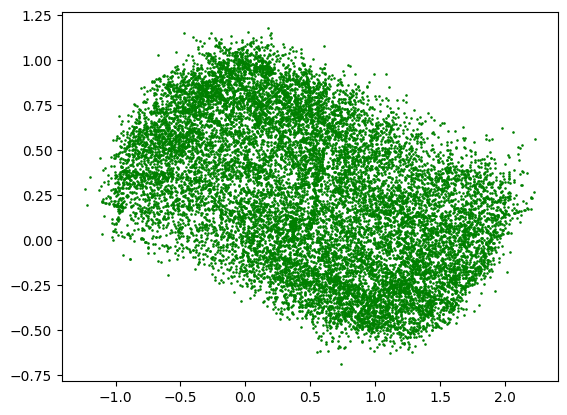

In [15]:
single_step_sampling_times = []

for _ in range(100):
    start = time.time()
    x_singlestep = consistency_single_step_sampling(model, device, batch_size=16384)
    end = time.time()
    single_step_sampling_times.append(end - start)
   
print(f"Single step sampling took {np.mean(single_step_sampling_times):.3f} +/- {np.std(single_step_sampling_times):.3f} seconds")

plt.scatter(x_singlestep[:,0], x_singlestep[:,1], s=0.75, c='g')

Multistep sampling took 0.086 +/- 0.017 seconds


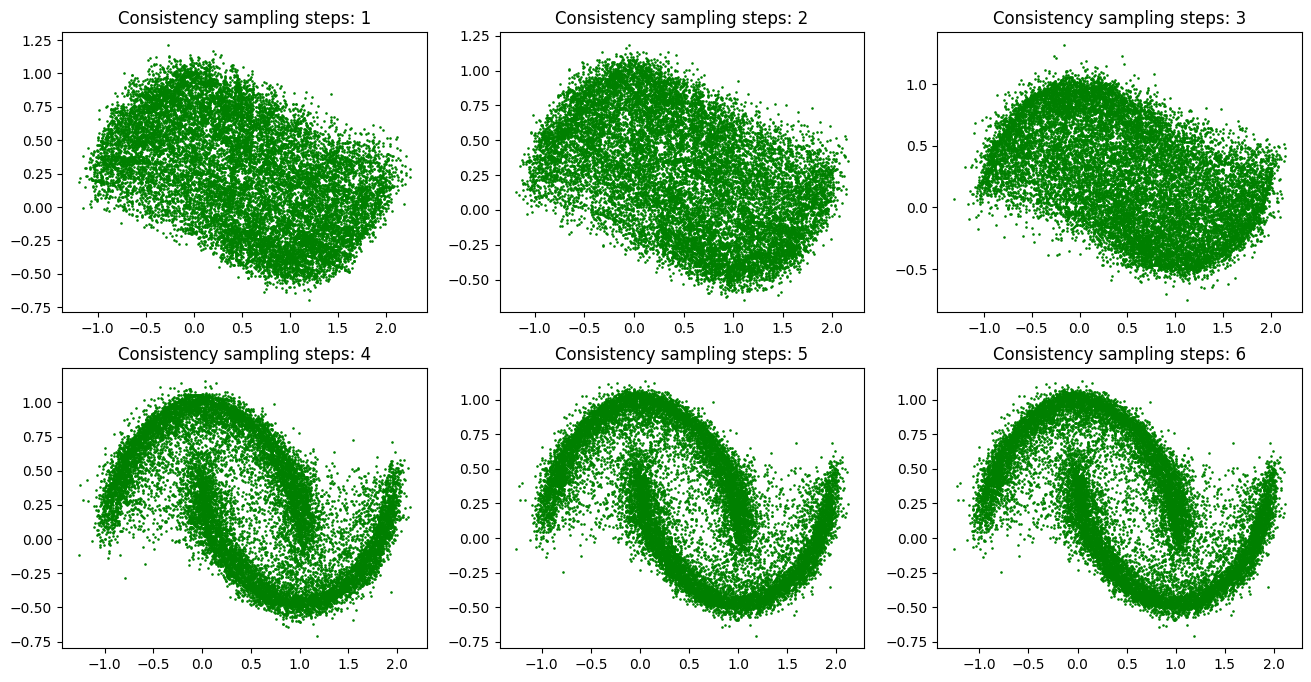

In [29]:
multi_step_sampling_times = []

times = np.round(np.logspace(np.log10(80), np.log10(0.002), 6), 3)

for _ in range(100):
    start = time.time()
    x_multistep_sampling = consistency_multiple_step_sampling(model, device, batch_size=16384, times=times)
    end = time.time()
    multi_step_sampling_times.append(end - start)

print(f"Multistep sampling took {np.mean(multi_step_sampling_times):.3f} +/- {np.std(multi_step_sampling_times):.3f} seconds")

# Calculate number of rows and columns
num_plots = len(x_multistep_sampling)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols  # Round up division

# Create a single figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

# Plotting
for i, X in enumerate(x_multistep_sampling):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].scatter(X[:,0], X[:,1], s=0.75, c='g')
    axes[row, col].set_title(f"Consistency sampling steps: {i+1}")
plt.show()

Text(0.5, 1.0, 'Isolated consistency model 6 steps sampling')

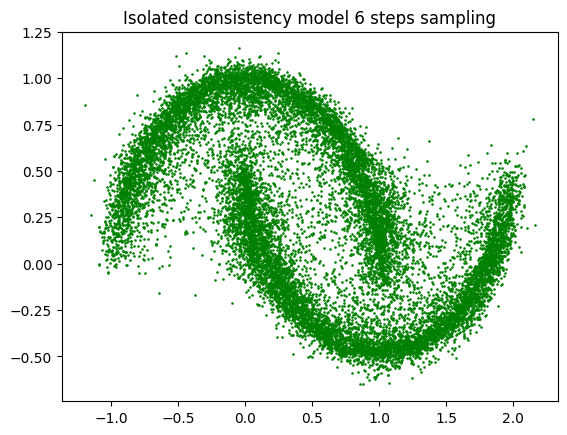

In [18]:
plt.scatter(x_multistep_sampling[-1][:,0], x_multistep_sampling[-1][:,1], s=0.75, c='g')
plt.title("Isolated consistency model 6 steps sampling")

In [24]:
print(x_multistep_sampling[-1].shape)

torch.Size([16384, 2])


In [27]:
# Compute the Euclidean distance matrix
M_singlestep = ot.dist(x_singlestep.cpu().numpy(), dataset.get_whole_dataset().cpu().numpy())
M_multistep = ot.dist(x_multistep_sampling[-1].cpu().numpy(), dataset.get_whole_dataset().cpu().numpy())

# Compute the Wasserstein distance
distance_singlestep = ot.emd2([], [], M_singlestep, numItermax=1e7)
distance_multistep = ot.emd2([], [], M_multistep, numItermax=1e7)

print(f"Wasserstein distance single step: {distance_singlestep:.4f}")
print(f"Wasserstein distance multi step: {distance_multistep:.4f}")


Wasserstein distance single step: 0.0514
Wasserstein distance multi step: 0.0317
